In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Cycle GAN
![Cycle-GAN](https://miro.medium.com/max/1838/0*S5gn5i6UhfyoRr9S.png)

## Step 1. Define Generator

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [6]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        
        # Inital Convolution  3*256*256 -> 64*256*256
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
        channels = out_channels
        
        # Downsampling   64*256*256 -> 128*128*128 -> 256*64*64
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        # Transformation (ResNet)  256*64*64
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        
        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

In [7]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_filters=64):
        super(UNetGenerator, self).__init__()
        
        # Encoder (Downsampling Path)
        self.enc1 = self.conv_block(in_channels, base_filters)
        self.enc2 = self.conv_block(base_filters, base_filters * 2)
        self.enc3 = self.conv_block(base_filters * 2, base_filters * 4)
        self.enc4 = self.conv_block(base_filters * 4, base_filters * 8)
        self.enc5 = self.conv_block(base_filters * 8, base_filters * 8)
        
        # Decoder (Upsampling Path)
        self.dec5 = self.upconv_block(base_filters * 8, base_filters * 8)
        self.dec4 = self.upconv_block(base_filters * 16, base_filters * 8)
        self.dec3 = self.upconv_block(base_filters * 12, base_filters * 4)
        self.dec2 = self.upconv_block(base_filters * 6, base_filters * 2)
        self.dec1 = nn.Conv2d(base_filters * 3, out_channels, kernel_size=3, stride=1, padding=1)
        
        # Final Activation (Tanh for Image Translation)
        self.final_act = nn.Tanh()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)   # 64 x 256 x 256
        e2 = self.enc2(e1)  # 128 x 128 x 128
        e3 = self.enc3(e2)  # 256 x 64 x 64
        e4 = self.enc4(e3)  # 512 x 32 x 32
        e5 = self.enc5(e4)  # 512 x 16 x 16
        
        # Decoder with skip connections
        d5 = self.dec5(e5)  # 512 x 32 x 32
        d4 = self.dec4(torch.cat([d5, e4], dim=1))  # 1024 x 32 x 32
        d3 = self.dec3(torch.cat([d4, e3], dim=1))  # 768 x 64 x 64
        d2 = self.dec2(torch.cat([d3, e2], dim=1))  # 384 x 128 x 128
        d1 = self.dec1(torch.cat([d2, e1], dim=1))  # 192 x 256 x 256
        
        # Final activation
        return self.final_act(d1)

In [30]:
class SmallUNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_filters=32):
        super(SmallUNetGenerator, self).__init__()
        
        # Encoder (Downsampling Path)
        self.enc1 = self.conv_block(in_channels, base_filters)        # 32 x 256 x 256
        self.enc2 = self.conv_block(base_filters, base_filters * 2)   # 64 x 128 x 128
        self.enc3 = self.conv_block(base_filters * 2, base_filters * 4) # 128 x 64 x 64
        self.enc4 = self.conv_block(base_filters * 4, base_filters * 8) # 256 x 32 x 32
        
        # Decoder (Upsampling Path)
        self.dec4 = self.upconv_block(base_filters * 8, base_filters * 4) # 256 x 64 x 64
        self.dec3 = self.upconv_block(base_filters * 8, base_filters * 2) # 128 x 128 x 128
        self.dec2 = self.upconv_block(base_filters * 4, base_filters)     # 64 x 256 x 256
        self.dec1 = nn.Conv2d(base_filters * 2, out_channels, kernel_size=3, stride=1, padding=1) # 3 x 256 x 256
        
        # Final Activation (Tanh for Image Translation)
        self.final_act = nn.Tanh()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)   # 32 x 256 x 256
        e2 = self.enc2(e1)  # 64 x 128 x 128
        e3 = self.enc3(e2)  # 128 x 64 x 64
        e4 = self.enc4(e3)  # 256 x 32 x 32
        
        # Decoder with correct skip connections
        d4 = self.dec4(torch.cat([e4, e3], dim=1))  # 256 x 64 x 64
        d3 = self.dec3(torch.cat([d4, e2], dim=1))  # 128 x 128 x 128
        d2 = self.dec2(torch.cat([d3, e1], dim=1))  # 64 x 256 x 256
        d1 = self.dec1(d2)  # 3 x 256 x 256
        
        # Final activation
        return self.final_act(d1)

## Step 2. Define Discriminator

In [31]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16
            
            # Why padding first then convolution?
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1) # 512*17*17 -> 1*16*16
        )
        
        self.scale_factor = 16
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        return self.model(x)

## Step 3. Define Loss

In [32]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

## Step 4. Initalize G and D

In [49]:
G_AB = GeneratorResNet(1)
D_B = Discriminator(1)

G_BA = GeneratorResNet(1)
D_A = Discriminator(1)

In [50]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

cuda: True


## Step 5. Configure Optimizers

In [51]:
import itertools
lr = 0.00001
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1, b2)
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1, b2)
)

## Step 6. Learning Rate Scheduler Setting

In [52]:
n_epoches = 100
decay_epoch = 20

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

## Step 7. DataLoader

In [53]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None):
        A_dir = os.path.join(data_dir, 'monet_jpg')
        B_dir = os.path.join(data_dir, 'photo_jpg')
        
        if mode == 'train':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[:80]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[:80]]
        elif mode == 'test':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[80:]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[80:]]
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files_A)
    
    def __getitem__(self, index):
        file_A = self.files_A[index]
        file_B = self.files_B[index]
        
        img_A = Image.open(file_A).convert("L")
        img_B = Image.open(file_B).convert("L")
        
        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)
        
        return img_A, img_B

In [54]:
import torchvision.transforms as transforms

data_dir = './archive/gan-getting-started 3/gan-getting-started 3'

transforms_ = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomCrop(256, 256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
batch_size = 5

trainloader = DataLoader(
    ImageDataset(data_dir, mode='train', transforms=transforms_),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 3
)

testloader = DataLoader(
    ImageDataset(data_dir, mode='test', transforms=transforms_),
    batch_size = batch_size,
    shuffle = False,
    num_workers = 3
)

## Step 8. Sample images to show

In [55]:
from torchvision.utils import make_grid

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, real_B, figside=1.5):
    print(real_A.size())
    print(real_B.size())
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()
    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()
    

torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


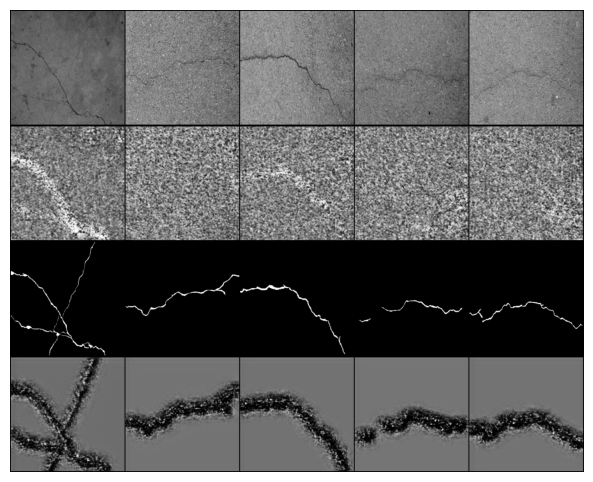

In [56]:
real_A, real_B = next(iter(testloader))
sample_images(real_A, real_B)

## Step 9. Training

torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


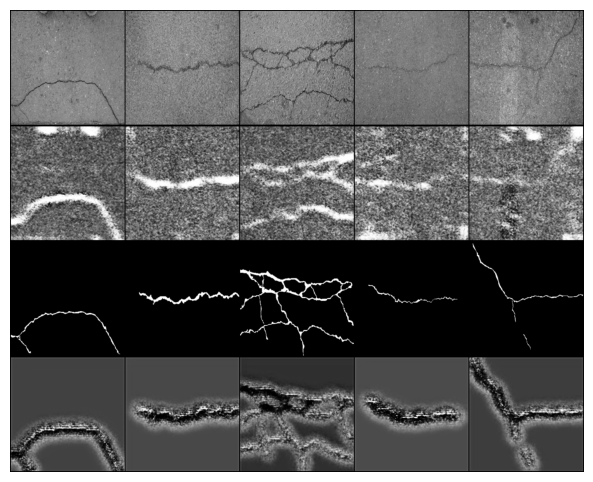

[Epoch 1/100]
[G loss: 7.433712005615234 | identity: 0.43944257497787476 GAN: 0.6624510288238525 cycle: 0.4574047923088074]
[D loss: 0.2865738570690155 | D_A: 0.33815157413482666 D_B: 0.23499612510204315]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


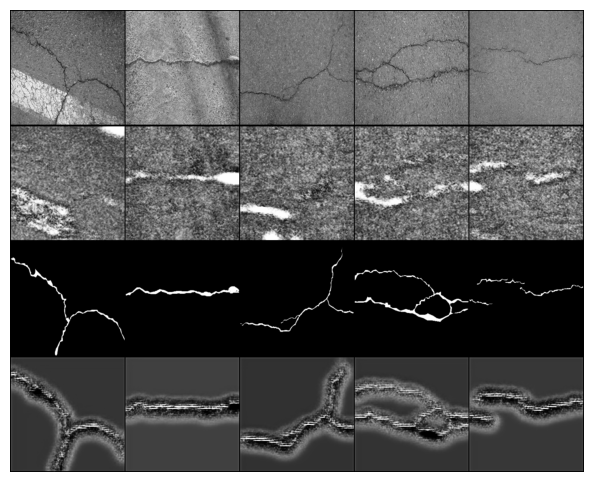

[Epoch 2/100]
[G loss: 5.799539566040039 | identity: 0.3925586938858032 GAN: 0.6378201246261597 cycle: 0.31989261507987976]
[D loss: 0.15183761715888977 | D_A: 0.18594102561473846 D_B: 0.11773420870304108]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


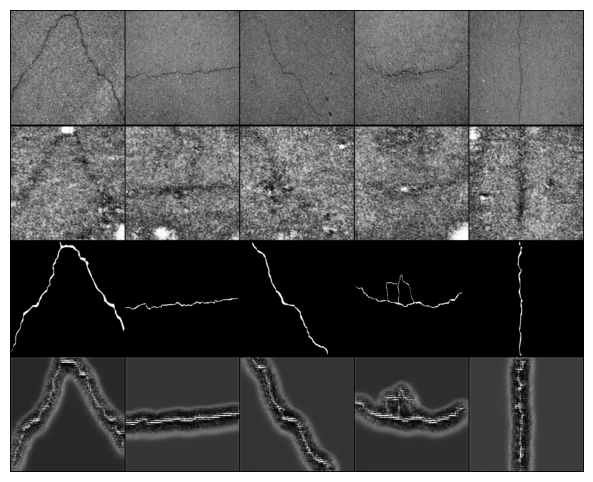

[Epoch 3/100]
[G loss: 5.100433349609375 | identity: 0.34890249371528625 GAN: 0.714665412902832 cycle: 0.2641255259513855]
[D loss: 0.10235364735126495 | D_A: 0.1250801682472229 D_B: 0.0796271339058876]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


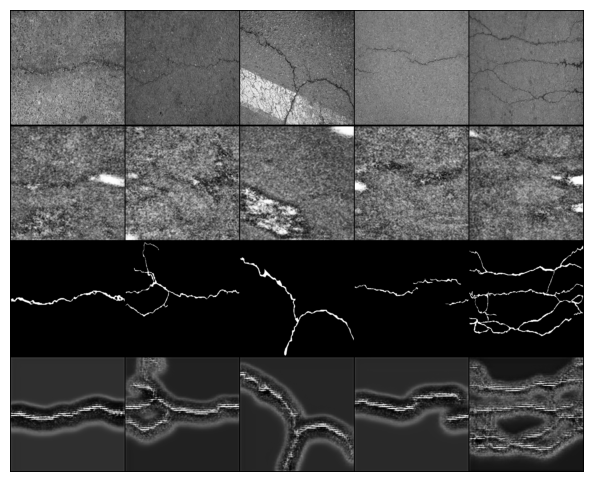

[Epoch 4/100]
[G loss: 4.842516899108887 | identity: 0.31190726161003113 GAN: 0.7592720985412598 cycle: 0.25237083435058594]
[D loss: 0.0766865611076355 | D_A: 0.09152286499738693 D_B: 0.061850257217884064]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


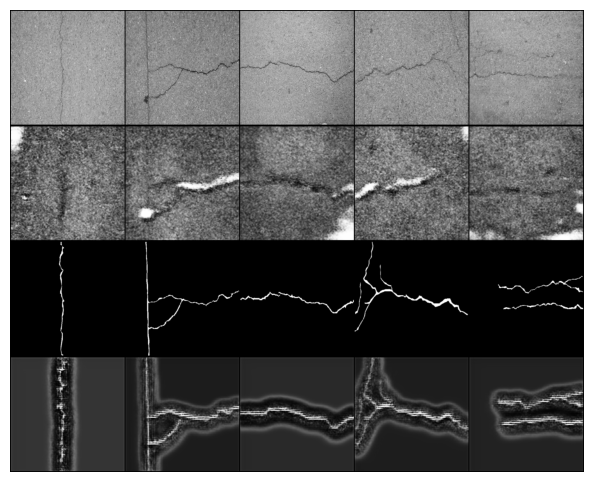

[Epoch 5/100]
[G loss: 4.75314998626709 | identity: 0.32283875346183777 GAN: 0.8485360145568848 cycle: 0.22904202342033386]
[D loss: 0.06126662716269493 | D_A: 0.0693947970867157 D_B: 0.053138457238674164]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


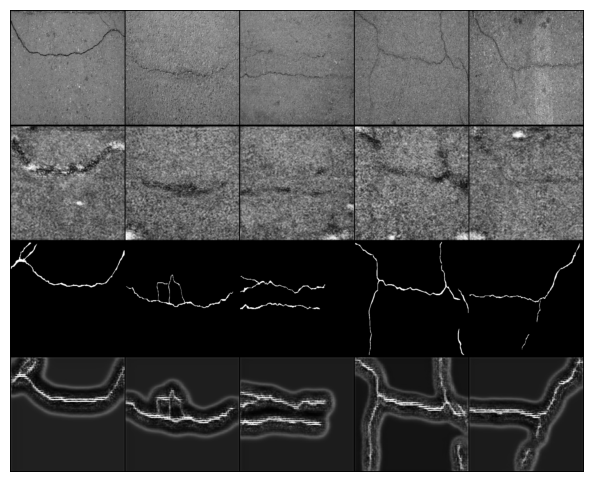

[Epoch 6/100]
[G loss: 4.319300651550293 | identity: 0.258009135723114 GAN: 0.8155506253242493 cycle: 0.2213703989982605]
[D loss: 0.07527731359004974 | D_A: 0.07216498255729675 D_B: 0.07838963717222214]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


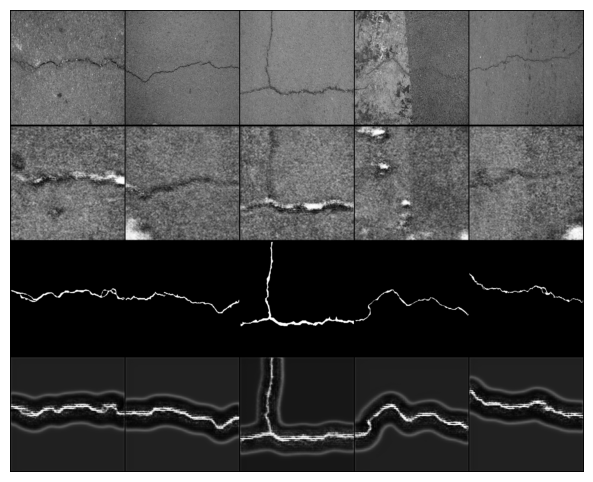

[Epoch 7/100]
[G loss: 4.241209983825684 | identity: 0.25160181522369385 GAN: 0.8431254625320435 cycle: 0.21400755643844604]
[D loss: 0.07143041491508484 | D_A: 0.07005377113819122 D_B: 0.07280705869197845]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


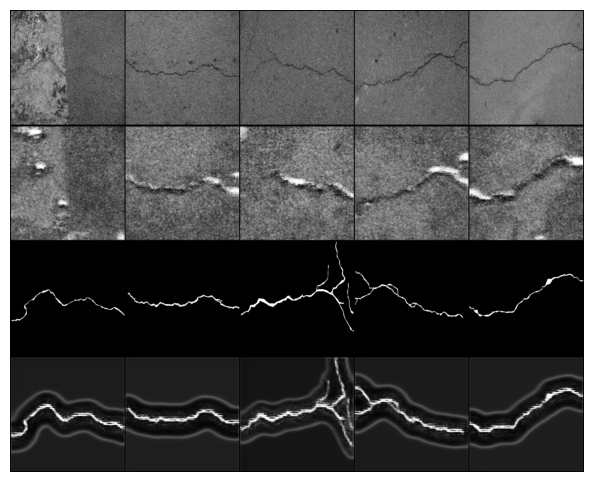

[Epoch 8/100]
[G loss: 4.079128265380859 | identity: 0.23917296528816223 GAN: 0.9439002871513367 cycle: 0.19393634796142578]
[D loss: 0.04265889525413513 | D_A: 0.0493973046541214 D_B: 0.03592048957943916]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


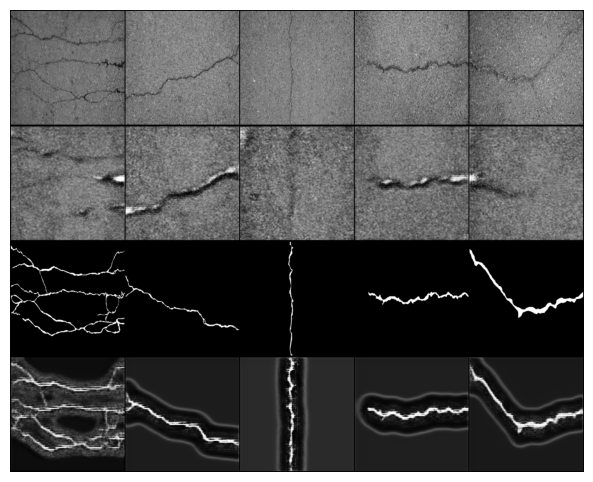

[Epoch 9/100]
[G loss: 3.7782185077667236 | identity: 0.2073606252670288 GAN: 0.9657373428344727 cycle: 0.17756779491901398]
[D loss: 0.029764795675873756 | D_A: 0.0299978069961071 D_B: 0.02953178435564041]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


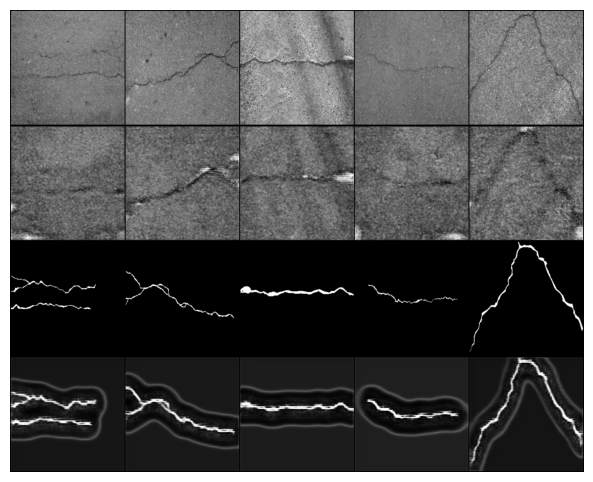

[Epoch 10/100]
[G loss: 3.77632212638855 | identity: 0.21122245490550995 GAN: 0.9645222425460815 cycle: 0.17556874454021454]
[D loss: 0.030040200799703598 | D_A: 0.03150156885385513 D_B: 0.028578830882906914]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


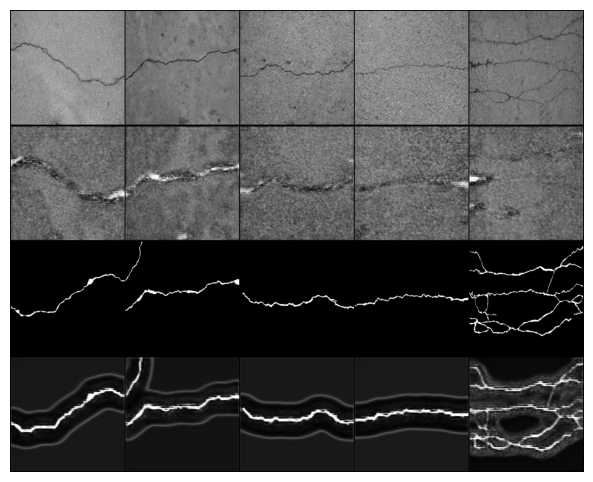

[Epoch 11/100]
[G loss: 3.74346923828125 | identity: 0.1961599886417389 GAN: 0.9544392824172974 cycle: 0.18082299828529358]
[D loss: 0.040783658623695374 | D_A: 0.03679642826318741 D_B: 0.04477088898420334]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


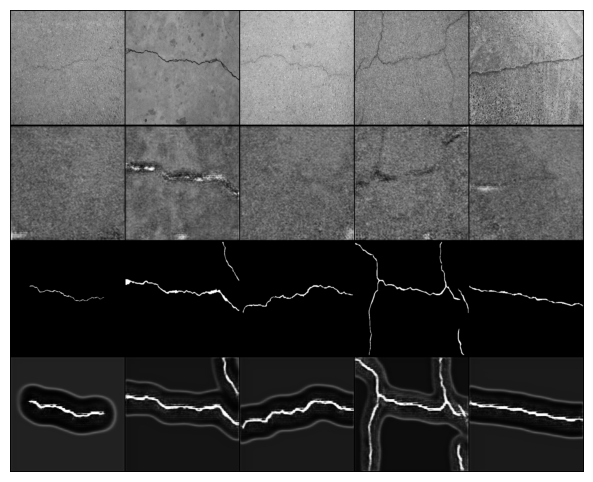

[Epoch 12/100]
[G loss: 3.5674333572387695 | identity: 0.19318750500679016 GAN: 0.9733134508132935 cycle: 0.16281823813915253]
[D loss: 0.02838268131017685 | D_A: 0.03028896450996399 D_B: 0.02647639811038971]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


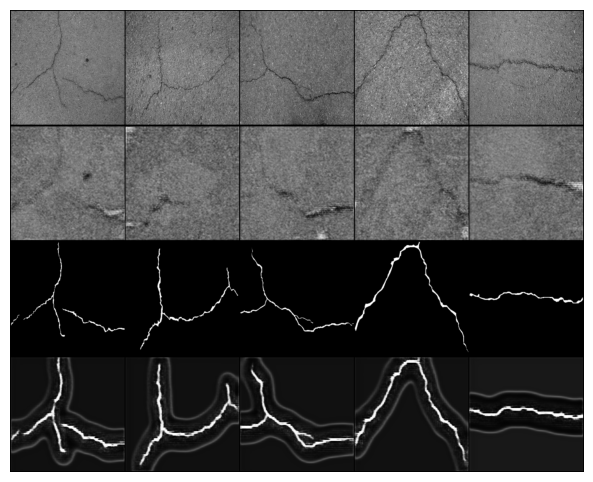

[Epoch 13/100]
[G loss: 3.592754602432251 | identity: 0.20134207606315613 GAN: 0.9465056657791138 cycle: 0.16395385563373566]
[D loss: 0.02701588347554207 | D_A: 0.02466759830713272 D_B: 0.029364170506596565]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


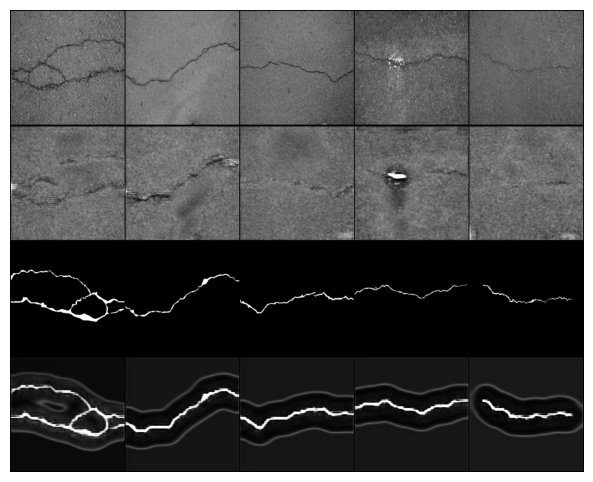

[Epoch 14/100]
[G loss: 3.5094008445739746 | identity: 0.19024117290973663 GAN: 0.9527907371520996 cycle: 0.16054043173789978]
[D loss: 0.041096821427345276 | D_A: 0.031126495450735092 D_B: 0.05106715112924576]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


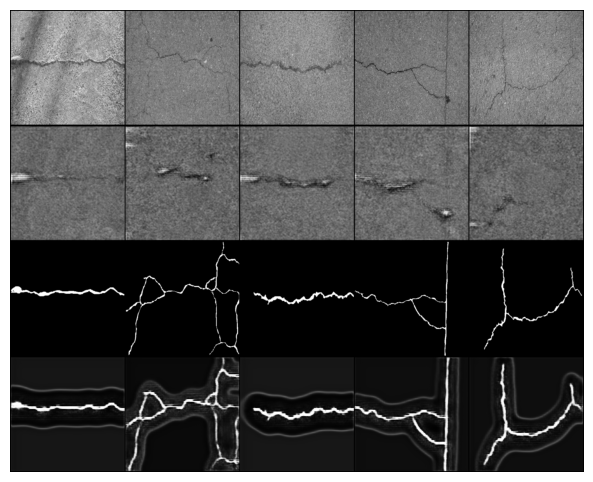

[Epoch 15/100]
[G loss: 3.4003376960754395 | identity: 0.18178032338619232 GAN: 0.9511370062828064 cycle: 0.15402990579605103]
[D loss: 0.02758767083287239 | D_A: 0.024491384625434875 D_B: 0.030683958902955055]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


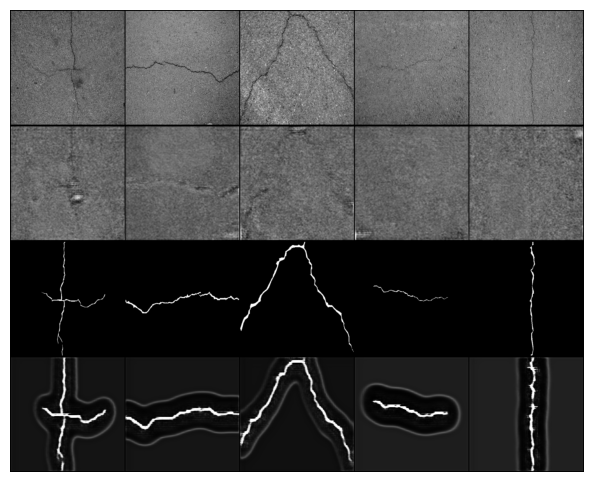

[Epoch 16/100]
[G loss: 3.2521183490753174 | identity: 0.1753644347190857 GAN: 0.924511730670929 cycle: 0.14507845044136047]
[D loss: 0.02935689128935337 | D_A: 0.023314647376537323 D_B: 0.03539913520216942]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


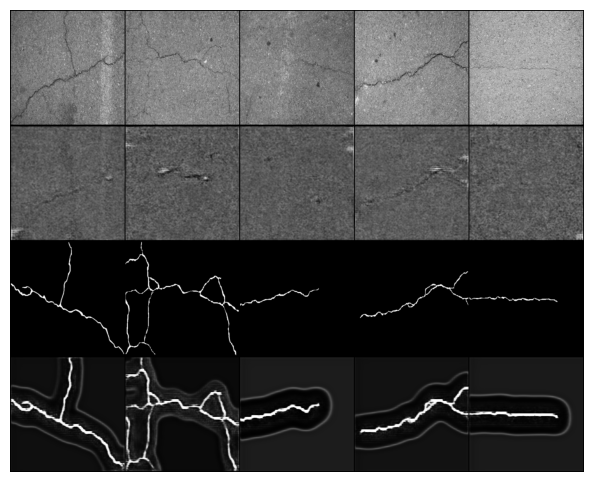

[Epoch 17/100]
[G loss: 3.237260341644287 | identity: 0.17332011461257935 GAN: 1.0033152103424072 cycle: 0.13673445582389832]
[D loss: 0.021626655012369156 | D_A: 0.020838189870119095 D_B: 0.022415122017264366]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


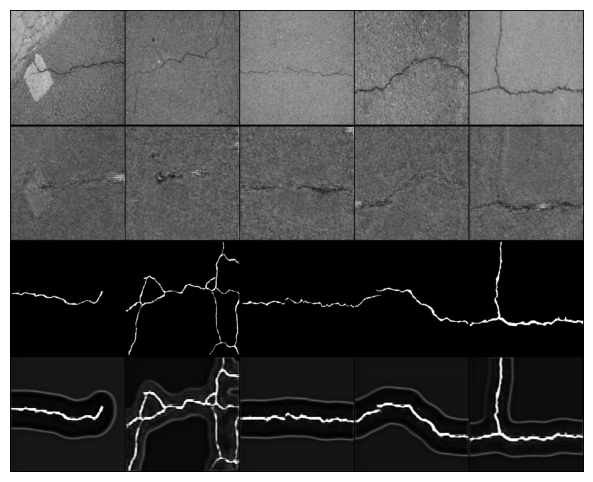

[Epoch 18/100]
[G loss: 3.3381733894348145 | identity: 0.19027364253997803 GAN: 0.9721108675003052 cycle: 0.14146943390369415]
[D loss: 0.021019011735916138 | D_A: 0.019073277711868286 D_B: 0.02296474575996399]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


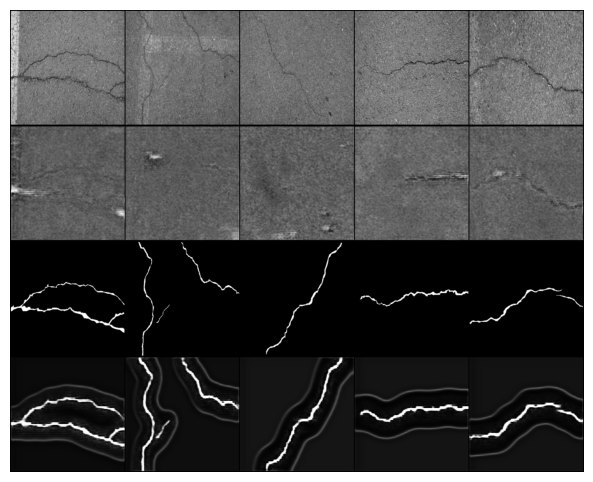

[Epoch 19/100]
[G loss: 3.160679817199707 | identity: 0.179160475730896 GAN: 0.9773827195167542 cycle: 0.12874945998191833]
[D loss: 0.020497936755418777 | D_A: 0.01807221584022045 D_B: 0.022923655807971954]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


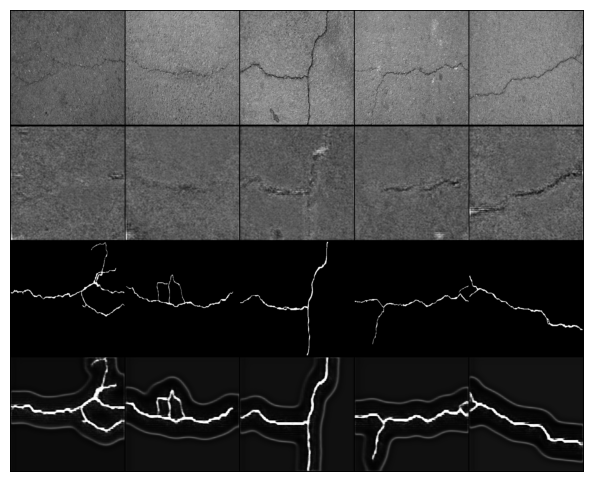

[Epoch 20/100]
[G loss: 3.181880474090576 | identity: 0.183415487408638 GAN: 0.9524697661399841 cycle: 0.1312333345413208]
[D loss: 0.024689743295311928 | D_A: 0.018964171409606934 D_B: 0.030415315181016922]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


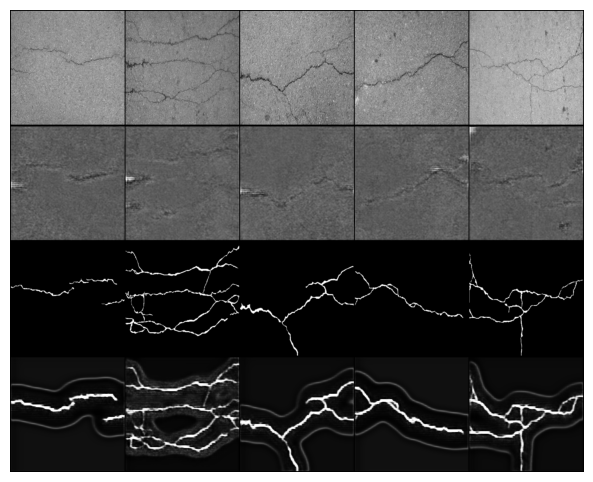

[Epoch 21/100]
[G loss: 3.2206835746765137 | identity: 0.17708849906921387 GAN: 0.9056819677352905 cycle: 0.14295591413974762]
[D loss: 0.03796778619289398 | D_A: 0.024174945428967476 D_B: 0.05176062509417534]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


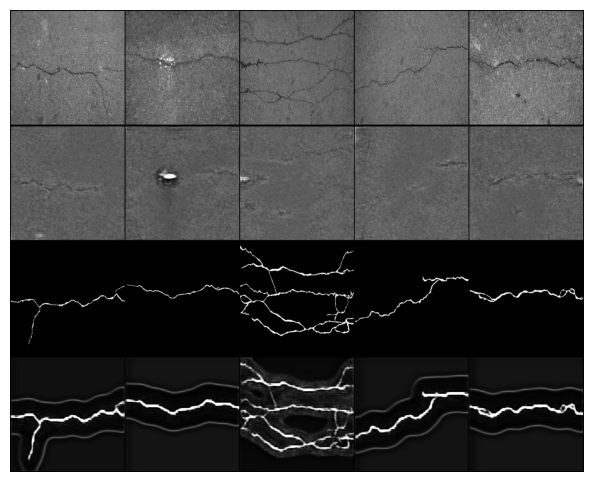

[Epoch 22/100]
[G loss: 3.138939380645752 | identity: 0.19316238164901733 GAN: 0.9278910756111145 cycle: 0.12452362477779388]
[D loss: 0.029353037476539612 | D_A: 0.01773928850889206 D_B: 0.040966786444187164]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


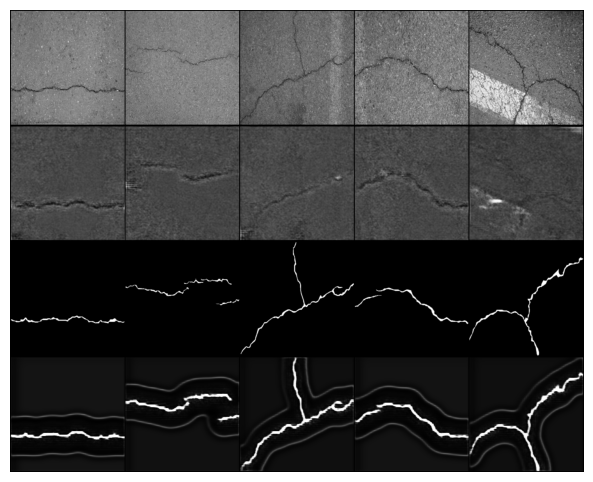

[Epoch 23/100]
[G loss: 3.211883783340454 | identity: 0.18216921389102936 GAN: 1.0052874088287354 cycle: 0.12957504391670227]
[D loss: 0.019281338900327682 | D_A: 0.017747633159160614 D_B: 0.020815042778849602]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


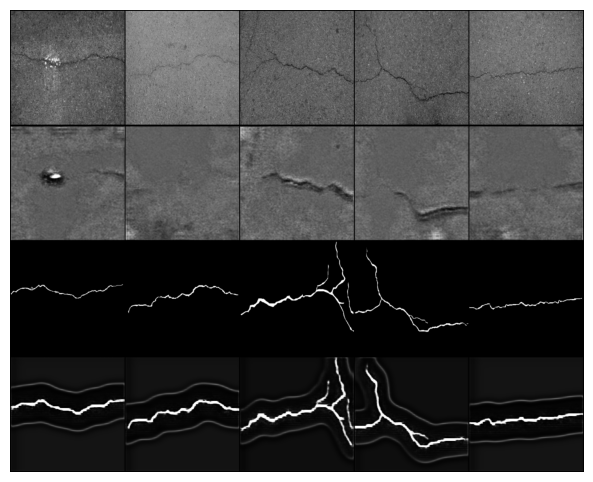

[Epoch 24/100]
[G loss: 3.1685543060302734 | identity: 0.18453098833560944 GAN: 1.0073015689849854 cycle: 0.12385979294776917]
[D loss: 0.0144154392182827 | D_A: 0.014554930850863457 D_B: 0.014275948517024517]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


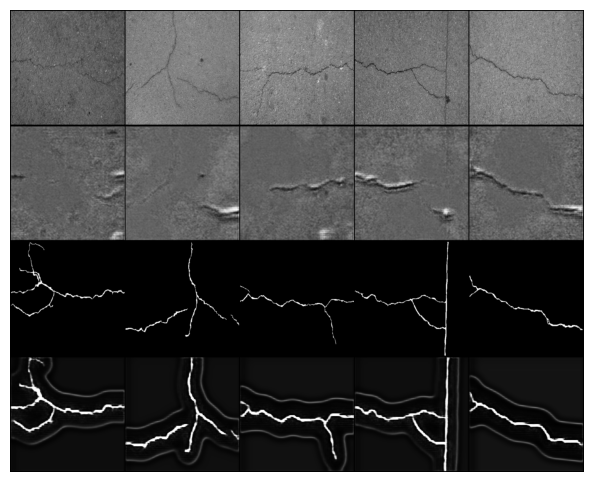

[Epoch 25/100]
[G loss: 3.0241239070892334 | identity: 0.18001416325569153 GAN: 0.9861009120941162 cycle: 0.1137952208518982]
[D loss: 0.014309910126030445 | D_A: 0.013680307194590569 D_B: 0.014939513057470322]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


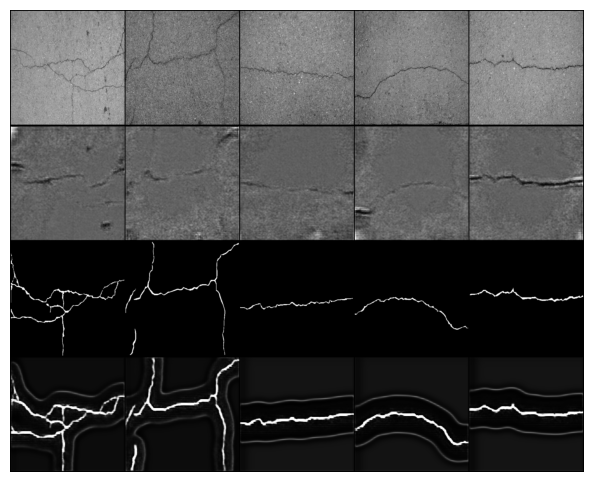

[Epoch 26/100]
[G loss: 3.0620455741882324 | identity: 0.1804707646369934 GAN: 0.9796913266181946 cycle: 0.11800004541873932]
[D loss: 0.018051763996481895 | D_A: 0.016511335968971252 D_B: 0.01959219202399254]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


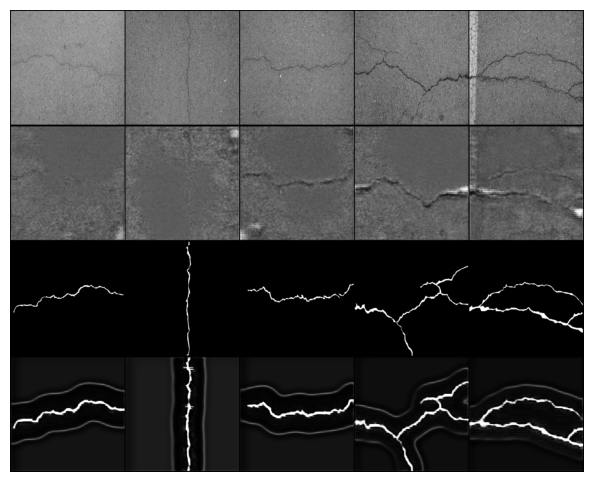

[Epoch 27/100]
[G loss: 3.1374051570892334 | identity: 0.18352267146110535 GAN: 1.0195722579956055 cycle: 0.12002195417881012]
[D loss: 0.014404693618416786 | D_A: 0.014229808934032917 D_B: 0.01457957737147808]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


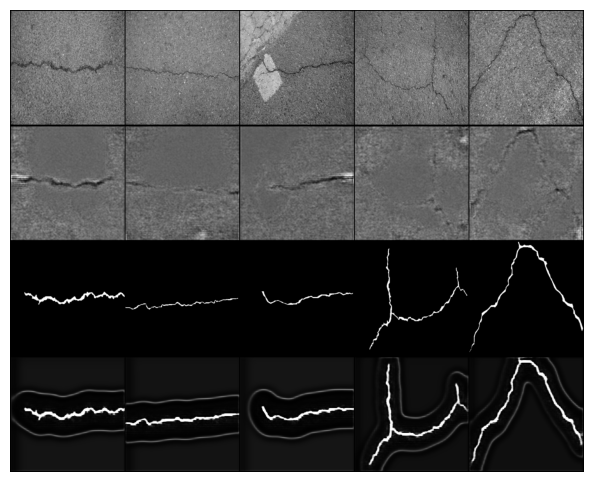

[Epoch 28/100]
[G loss: 3.008726119995117 | identity: 0.18412569165229797 GAN: 1.0099108219146729 cycle: 0.10781867802143097]
[D loss: 0.011950109153985977 | D_A: 0.01179064717143774 D_B: 0.012109571136534214]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


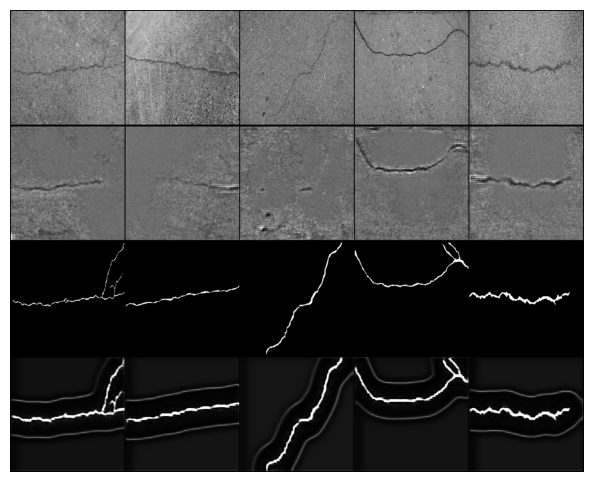

[Epoch 29/100]
[G loss: 2.9625720977783203 | identity: 0.17582759261131287 GAN: 0.9829798340797424 cycle: 0.110045425593853]
[D loss: 0.01280873455107212 | D_A: 0.01309366524219513 D_B: 0.012523802928626537]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


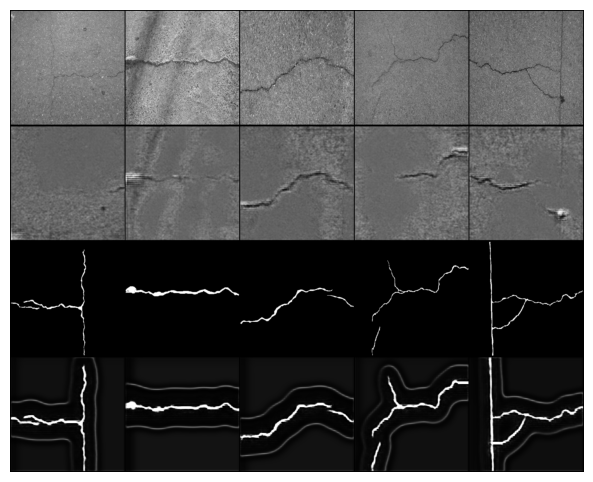

[Epoch 30/100]
[G loss: 2.8289542198181152 | identity: 0.1586688905954361 GAN: 0.946425199508667 cycle: 0.1089184358716011]
[D loss: 0.015129582956433296 | D_A: 0.014300022274255753 D_B: 0.01595914363861084]
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])


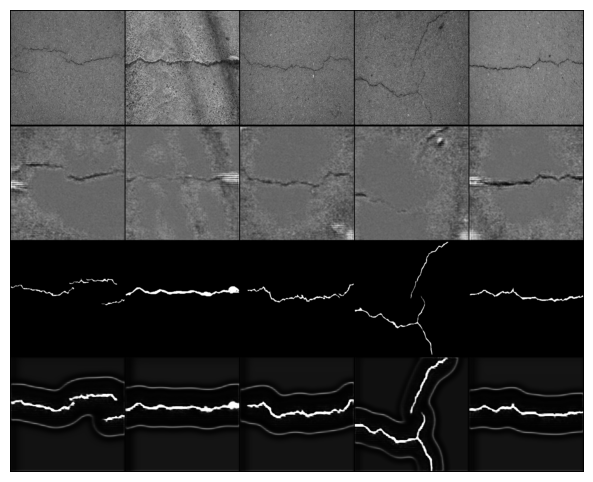

[Epoch 31/100]
[G loss: 3.080413341522217 | identity: 0.17477945983409882 GAN: 1.0069652795791626 cycle: 0.11995506286621094]
[D loss: 0.01269939262419939 | D_A: 0.013062885962426662 D_B: 0.012335899285972118]


In [ ]:
for epoch in range(n_epoches):
    for i, (real_A, real_B) in enumerate(trainloader):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)
        
        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        """Train Generators"""
        # set to training mode in the begining, beacause sample_images will set it to eval mode
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        
        # identity loss
        loss_id_A = criterion_identity(fake_B, real_A)
        loss_id_B = criterion_identity(fake_A, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss, train G to make D think it's true
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) 
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # G totol loss
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator A"""
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        """Train Discriminator B"""
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # test
    if (epoch+1) % 1== 0:
        test_real_A, test_real_B = next(iter(trainloader))
        sample_images(test_real_A, test_real_B)

        loss_D = (loss_D_A + loss_D_B) / 2
        print(f'[Epoch {epoch+1}/{n_epoches}]')
        print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')    

## Step 10. Generate Images

In [ ]:
photo_dir = os.path.join(data_dir, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
len(files)

In [ ]:
save_dir = '../images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = transforms.ToPILImage()

G_BA.eval()
for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = generate_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)
    
    # generate
    fake_imgs = G_BA(imgs).detach().cpu()
    
    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)
        
        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")